#**Import Packages**

In [1]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img, array_to_img
from tensorflow.keras.optimizers import Adam,RMSprop,SGD
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, LeakyReLU
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import Recall, Precision
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.layers import GlobalAveragePooling2D, Dense, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras import models
import os
import cv2
import shutil
import random
import matplotlib.pyplot as plt
from torchvision import transforms
from PIL import ImageEnhance, Image
from collections import Counter
from tqdm import tqdm

#**Import Dataset**

In [2]:
from google.colab import drive
drive.mount('/content/drive')

zip_path = '/content/drive/MyDrive/dataset_food.zip'

!unzip -q "/content/drive/MyDrive/dataset_food.zip" -d "/content/"

Mounted at /content/drive


Dataset yang akan gunakan adalah dataset makanan Indonesia yang diambil sebagian dari Kaggle.

#**Resolusi gambar**

In [3]:
dataset_path = '/content/dataset_food'

# Simpan semua resolusi
resolutions = []

for root, dirs, files in os.walk(dataset_path):
    for file in files:
        if file.endswith(('.jpg', '.jpeg', '.png')):
            try:
                img_path = os.path.join(root, file)
                img = Image.open(img_path)
                resolutions.append(img.size)  # (width, height)
            except:
                continue

# Hitung dan tampilkan ukuran yang paling umum
res_counter = Counter(resolutions)
print("Top 10 resolusi gambar yang ditemukan:")
print(res_counter.most_common(10))

# Total variasi resolusi
print(f"\nTotal variasi resolusi unik: {len(set(resolutions))}")

Top 10 resolusi gambar yang ditemukan:
[((299, 299), 4814), ((720, 720), 8), ((1200, 1200), 7), ((200, 200), 7), ((768, 768), 5), ((450, 450), 5), ((393, 393), 5), ((360, 360), 4), ((333, 333), 4), ((363, 363), 4)]

Total variasi resolusi unik: 324


dataset asli memiliki resolusi gambar yang tidak seragam (tanpa preprocessing), dengan 324 variasi ukuran berbeda yang terbukti dari analisis data.

#**Pra-pemrosesan Data Gambar**

In [4]:
class_counts = {}
for class_name in os.listdir(dataset_path):
    class_dir = os.path.join(dataset_path, class_name)
    if os.path.isdir(class_dir):
        class_counts[class_name] = len(os.listdir(class_dir))

for class_name, count in class_counts.items():
    print(f"Class: {class_name}, Jumlah Data: {count}")

Class: valid, Jumlah Data: 5
Class: test, Jumlah Data: 5
Class: train, Jumlah Data: 5


Dataset terbagi menjadi 3 kelas direktori (valid, test, train), masing-masing berisi 5 data.

In [5]:
def count_images_in_directory(directory):
    total_images = 0
    for class_dir in os.listdir(directory):
        class_path = os.path.join(directory, class_dir)
        if os.path.isdir(class_path):
            total_images += len(os.listdir(class_path))
    return total_images

train_dir = '/content/dataset_food/train'
valid_dir = '/content/dataset_food/valid'
test_dir = '/content/dataset_food/test'

total_train = count_images_in_directory(train_dir)
total_valid = count_images_in_directory(valid_dir)
total_test = count_images_in_directory(test_dir)

print(f"Total gambar di TRAIN SET: {total_train}")
print(f"Total gambar di VALIDATION SET: {total_valid}")
print(f"Total gambar di TEST SET: {total_test}")
print(f"Total keseluruhan: {total_train + total_valid + total_test}")


Total gambar di TRAIN SET: 3949
Total gambar di VALIDATION SET: 902
Total gambar di TEST SET: 432
Total keseluruhan: 5283


- train mempunyai  3949 gabar
- valid mempnyai 902 gambar
- test mempunyai 432 gambr
- ▶ total semua nya  5283 gambar tidak memenuhi syarat penlaian yang harus 10.000 data. maka dari itu Train saya akan Augmentasi statis







##Augmentasi statis

Kelas sate: 916 gambar
Augmentasi selesai untuk kelas sate
Kelas gado: 879 gambar
Augmentasi selesai untuk kelas gado
Kelas bakso: 874 gambar
Augmentasi selesai untuk kelas bakso
Kelas gudeg: 375 gambar
Augmentasi selesai untuk kelas gudeg
Kelas rendang: 905 gambar
Augmentasi selesai untuk kelas rendang

Menampilkan sampel dari kelas yang sudah memenuhi 1800 gambar:



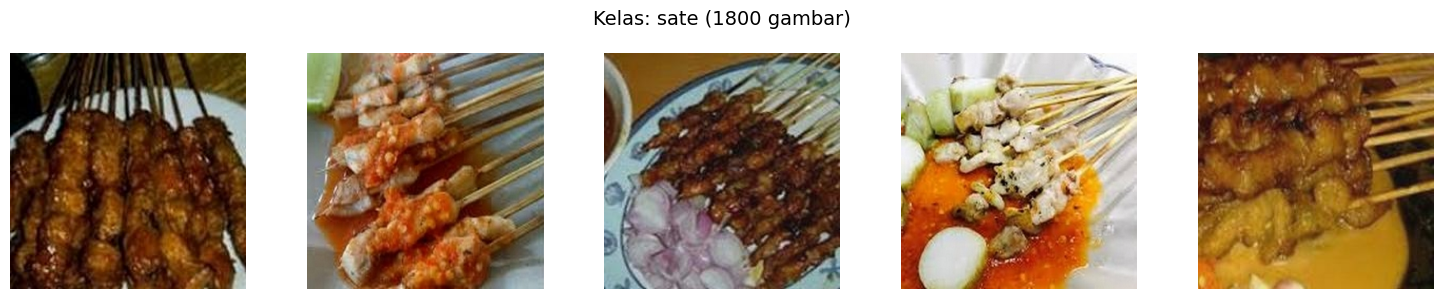

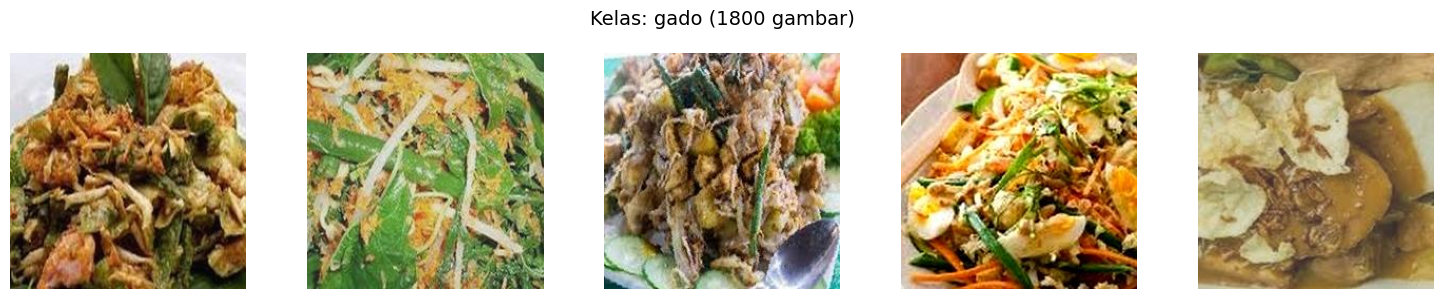

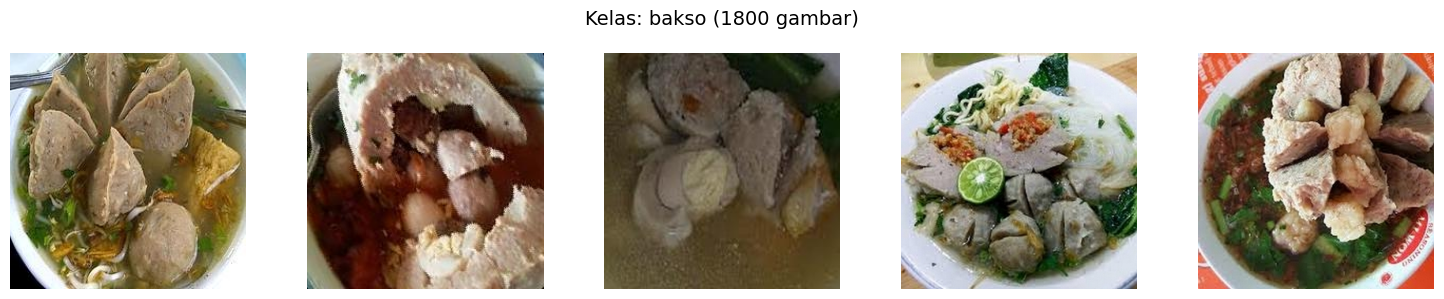

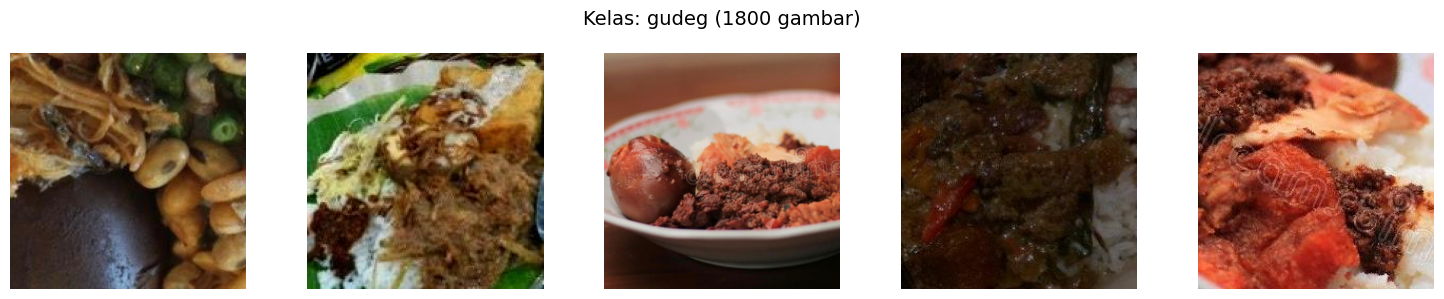

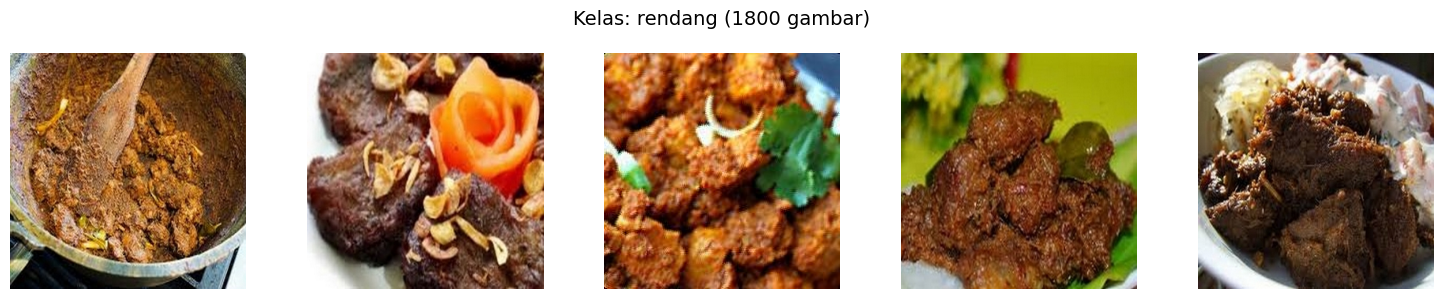

In [6]:
# Path ke folder training
train_dir = '/content/dataset_food/train'
target_per_class = 1800

# Daftar transformasi
augmentations = [
    transforms.Compose([transforms.RandomVerticalFlip(p=1)]),
    transforms.Compose([transforms.RandomHorizontalFlip(p=1)]),
    transforms.Compose([transforms.RandomAffine(degrees=0, translate=(0.2, 0))]),  # horizontal shift
    transforms.Compose([transforms.RandomAffine(degrees=0, translate=(0, 0.2))]),  # vertical shift
    transforms.Compose([transforms.RandomRotation(degrees=30)]),
    transforms.Compose([transforms.RandomRotation(degrees=(-30, 0))]),
    transforms.Compose([transforms.ColorJitter(brightness=0.5)]),  # brightness adjustment
    transforms.Compose([transforms.ColorJitter(brightness=(0.5, 1))]),  # darkness
    transforms.Compose([transforms.ColorJitter(contrast=(1, 1.5))]),  # contrast up
    transforms.Compose([transforms.ColorJitter(contrast=(0.5, 1))])   # contrast down
]

# Fungsi crop tengah (kalau butuh)
def crop_image(image, size):
    width, height = image.size
    left = (width - size) / 2
    top = (height - size) / 2
    right = (width + size) / 2
    bottom = (height + size) / 2
    cropped_image = image.crop((left, top, right, bottom))
    return cropped_image

# Untuk setiap kelas
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    current_count = len(images)
    print(f"Kelas {class_name}: {current_count} gambar")

    if current_count < target_per_class:
        needed = target_per_class - current_count
        generated = 0
        while generated < needed:
            image_name = random.choice(images)
            image_path = os.path.join(class_path, image_name)
            image = Image.open(image_path).convert("RGB")

            transform = random.choice(augmentations)  # Pilih salah satu transformasi
            aug_img = transform(image)

            # Crop tengah jika resolusi besar
            if aug_img.size[0] > 224 and aug_img.size[1] > 224:
                aug_img = crop_image(aug_img, 224)

            aug_name = f"aug_{generated}_{image_name}"
            aug_path = os.path.join(class_path, aug_name)
            aug_img.save(aug_path)
            generated += 1

        print(f"Augmentasi selesai untuk kelas {class_name}")

# Tampilkan 5 gambar dari kelas yang sudah memenuhi target
print("\nMenampilkan sampel dari kelas yang sudah memenuhi 1800 gambar:\n")
for class_name in os.listdir(train_dir):
    class_path = os.path.join(train_dir, class_name)
    if not os.path.isdir(class_path):
        continue

    images = [f for f in os.listdir(class_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    if len(images) >= target_per_class:
        sample_imgs = random.sample(images, min(5, len(images)))
        fig, axs = plt.subplots(1, 5, figsize=(15, 3))
        fig.suptitle(f'Kelas: {class_name} ({len(images)} gambar)', fontsize=14)
        for ax, img_name in zip(axs, sample_imgs):
            img_path = os.path.join(class_path, img_name)
            img = Image.open(img_path)
            ax.imshow(img)
            ax.axis('off')
        plt.tight_layout()
        plt.show()


seperti yang sudah saya jelaskan di atas karna data nya hanya ada 5000an maka dari itu data daritrain yang setiap kelasnya saya augmentasi statis yang setiap kelas sebanyak 1800 gambar augmentasi

In [8]:
base_dir = '/content/dataset_food'
batch_size = 32

#Training set
train_dir = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'train'),
    image_size=(224, 224), # Changed image_size to (224, 224)
    batch_size=batch_size,
    label_mode='categorical'
)

# Validation set
valid_dir = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'valid'),
    image_size=(224, 224), # Changed image_size to (224, 224)
    batch_size=batch_size,
    label_mode='categorical'
)

#Test set
test_dir = tf.keras.utils.image_dataset_from_directory(
    os.path.join(base_dir, 'test'),
    image_size=(224, 224), # Changed image_size to (224, 224)
    batch_size=batch_size,
    label_mode='categorical'
)

Found 9000 files belonging to 5 classes.
Found 902 files belonging to 5 classes.
Found 432 files belonging to 5 classes.


memuat dataset gambar dari tiga folder: train, valid, dan test.
Setiap gambar diresize menjadi ukuran 224x224 agar sesuai dengan input model EfficientNetB0.
Label gambar secara otomatis diambil dari nama subfolder dan dikonversi menjadi one-hot encoding.
label_mode='categorical' digunakan karena model menggunakan softmax dan categorical_crossentropy.
Dataset train_dir dipakai untuk melatih model, valid_dir untuk validasi selama training, dan test_dir untuk pengujian akhir.
Dengan fungsi ini, TensorFlow bisa langsung membaca, memberi label, dan membatch data gambar dari struktur folder.

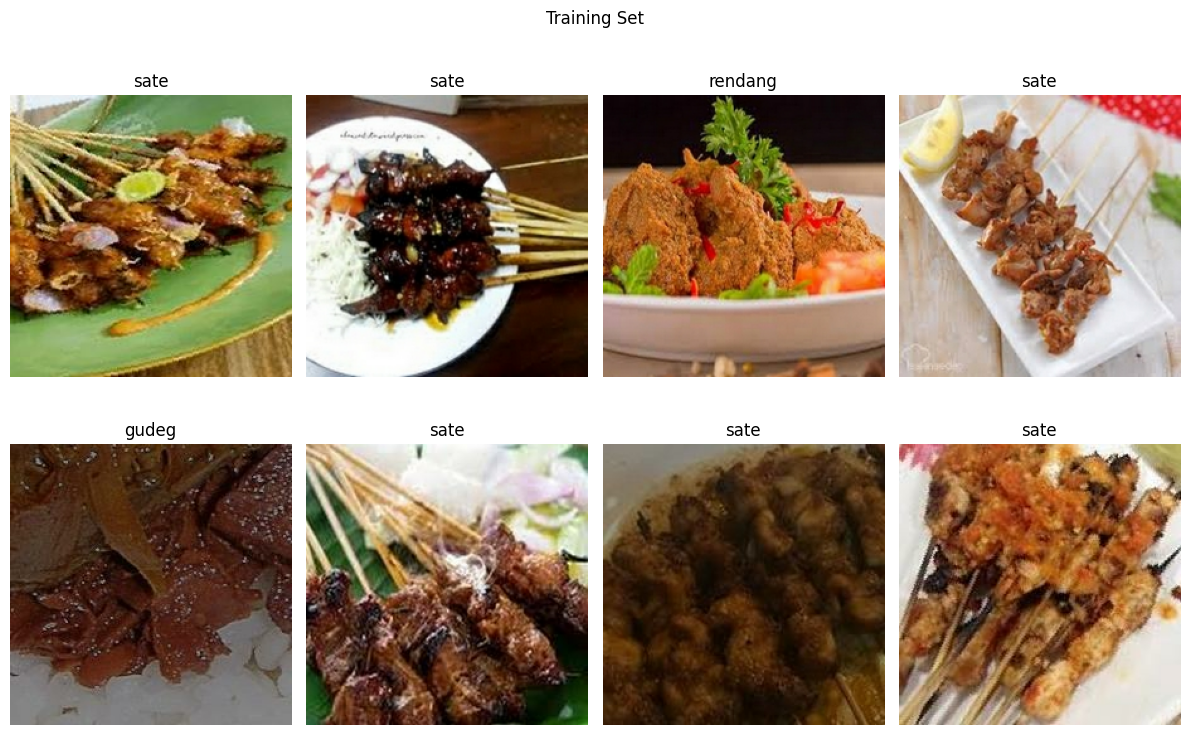

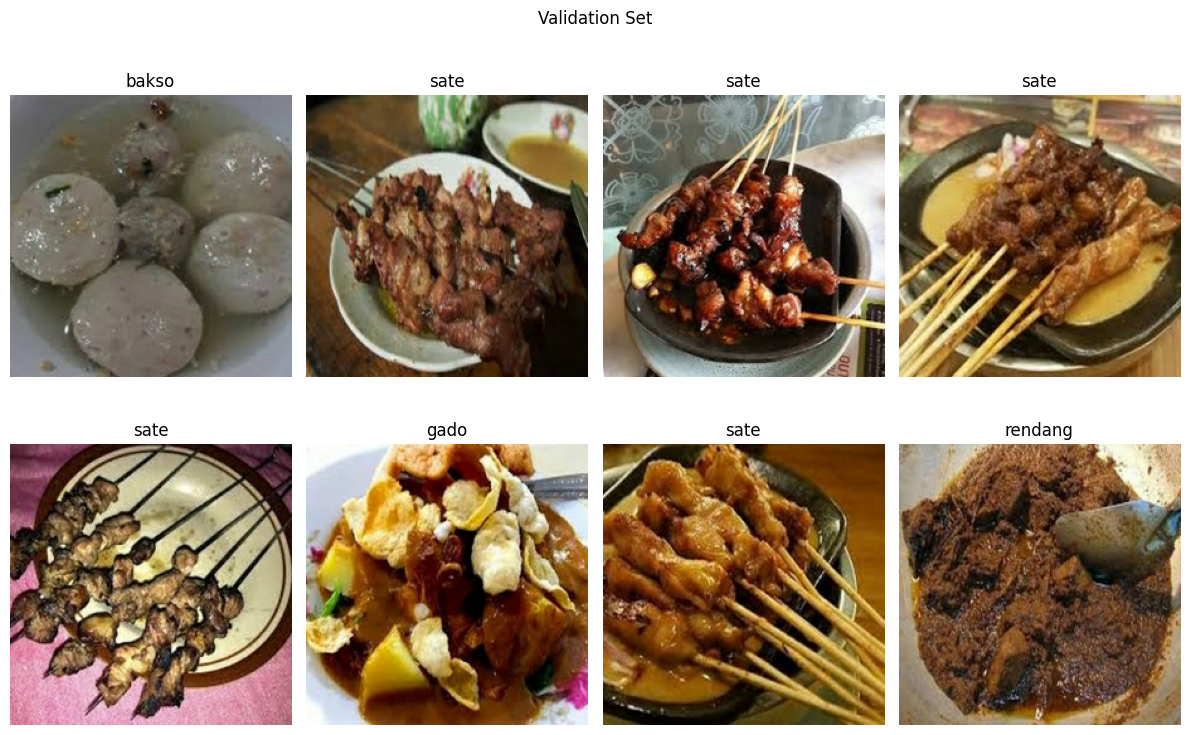

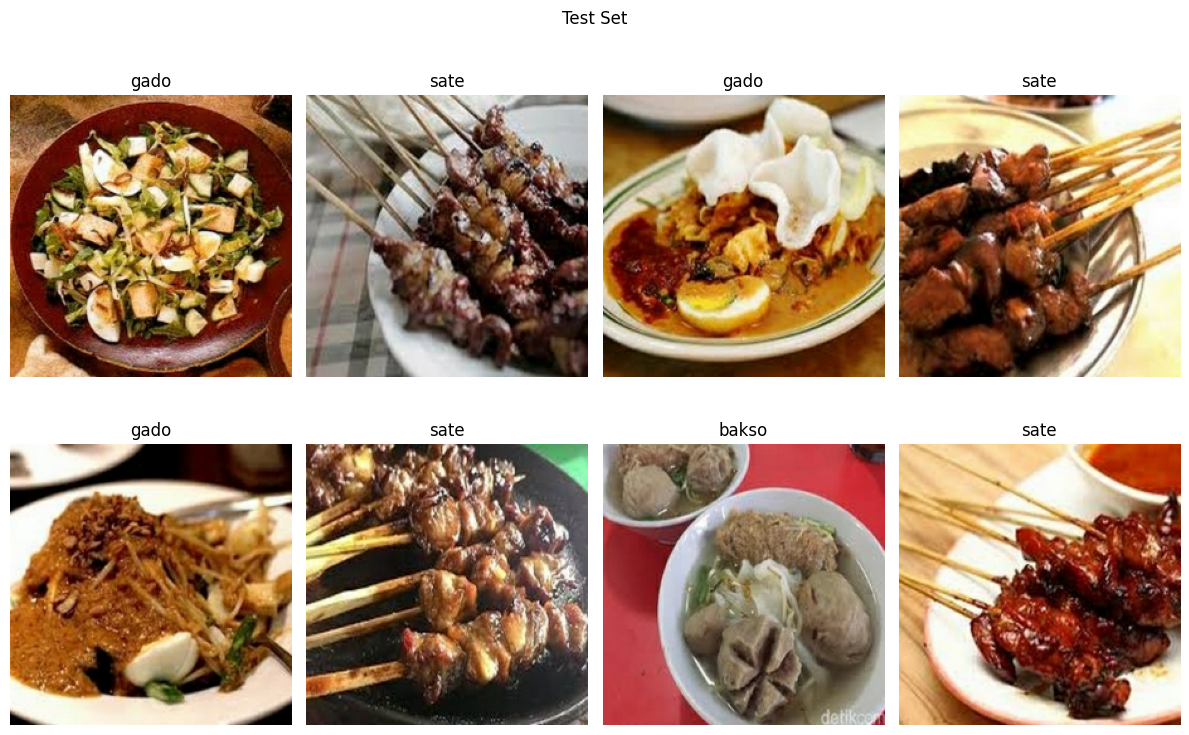

In [9]:
class_names = train_dir.class_names


def show_images(dataset, title="Split Preview"):
    plt.figure(figsize=(12, 8))
    for images, labels in dataset.take(1):
        for i in range(8):
            ax = plt.subplot(2, 4, i + 1)
            plt.imshow(images[i].numpy().astype("uint8"))
            label_index = tf.argmax(labels[i]).numpy()
            plt.title(class_names[label_index])
            plt.axis("off")
    plt.suptitle(title)
    plt.tight_layout()
    plt.show()

show_images(train_dir, title="Training Set")
show_images(valid_dir, title="Validation Set")
show_images(test_dir, title="Test Set")

##Augmentasi dinamis

In [10]:
# Data augmentasi
import tensorflow as tf # Make sure to import tensorflow

# Import layers explicitly.
from tensorflow.keras import layers

data_augmentation = tf.keras.Sequential([
    layers.RandomFlip("both"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
    layers.RandomContrast(0.1),
    layers.RandomShear(0.1),
])


#**ModeL CNN**

In [11]:
# Memuat model EfficientNetB0
base_model = EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224, 224, 3))

# Membekukan semua layer pada base model
base_model.trainable = False
num_classes = len(class_names)
# Membuat model tambahan untuk fine-tuning
model = models.Sequential([
    base_model,
    GlobalAveragePooling2D(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

# Menyusun model
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

model.summary()

16705208/16705208 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ efficientnetb0 (Functional)     │ (None, 7, 7, 1280)     │     4,049,571 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 1280)           │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 1280)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       163,968 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 5)              │           645 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,214,184 (16.08 MB)

 Trainable params: 164,613 (643.02 KB)

 Non-trainable params: 4,049,571 (15.45 MB)

Model ini menggunakan arsitektur EfficientNetB0 yang sudah dilatih sebelumnya pada dataset ImageNet.
Seluruh layer dari EfficientNet dibekukan (tidak dilatih ulang), berfungsi sebagai feature extractor.
Fitur yang dihasilkan diratakan menggunakan GlobalAveragePooling2D menjadi vektor 1 dimensi.
Kemudian ditambahkan layer Dropout untuk mencegah overfitting, dan dua Dense layer untuk klasifikasi.
Model ini hanya melatih bagian atas (head) dengan jumlah parameter trainable sebanyak 164.613.
Tujuan penggunaan transfer learning ini adalah agar model cepat belajar dengan akurasi tinggi menggunakan data terbatas.

#**Training Model + Callback**

In [12]:
class myCallback(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs={}):
    if(logs.get('val_accuracy')>0.96 and logs.get('accuracy')>0.96):
      print("\nAkurasi telah mencapai > 96%!")
      self.model.stop_training = True
callbacks = myCallback()

In [13]:
# latih model
history = model.fit(
    train_dir,
    validation_data=valid_dir,
    epochs=50,
    callbacks=[callbacks]
)

Epoch 1/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 80s 180ms/step - accuracy: 0.8222 - loss: 0.5046 - val_accuracy: 0.9390 - val_loss: 0.1831
Epoch 2/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 65ms/step - accuracy: 0.9417 - loss: 0.1783 - val_accuracy: 0.9446 - val_loss: 0.1472
Epoch 3/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step - accuracy: 0.9407 - loss: 0.1648 - val_accuracy: 0.9523 - val_loss: 0.1482
Epoch 4/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 18s 43ms/step - accuracy: 0.9515 - loss: 0.1390 - val_accuracy: 0.9523 - val_loss: 0.1434
Epoch 5/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 21s 46ms/step - accuracy: 0.9549 - loss: 0.1301 - val_accuracy: 0.9501 - val_loss: 0.1382
Epoch 6/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 23s 55ms/step - accuracy: 0.9566 - loss: 0.1307 - val_accuracy: 0.9568 - val_loss: 0.1310
Epoch 7/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 17s 59ms/step - accuracy: 0.9649 - loss: 0.1048 - val_accuracy: 0.9523 - val_loss: 0.1368
Epoch 8/50
282/282 ━━━━━━━━━━━━━━━━━━━━ 21s 62ms/step - accuracy: 0.9649 - loss: 0.0971 -

In [14]:
test_loss, test_acc = model.evaluate(valid_dir)
train_loss, train_acc = model.evaluate(train_dir)

print(f"Akurasi training(train_accuracy): {train_acc:.2%}")
print(f"Akurasi testing(val_accuracy): {test_acc:.2%}")

29/29 ━━━━━━━━━━━━━━━━━━━━ 1s 49ms/step - accuracy: 0.9635 - loss: 0.1012
282/282 ━━━━━━━━━━━━━━━━━━━━ 17s 61ms/step - accuracy: 0.9948 - loss: 0.0226
Akurasi training(train_accuracy): 99.69%
Akurasi testing(val_accuracy): 96.01%


Model berhasil mencapai akurasi training sebesar 99.70%, yang menunjukkan bahwa model sangat baik dalam mengenali data yang telah dilatih.
Pada data validasi/testing, model mencapai akurasi 96.12%, yang berarti performanya tetap tinggi pada data yang belum pernah dilihat.
Nilai loss pada data training hanya 0.0176, menunjukkan kesalahan prediksi sangat kecil terhadap label asli.
Sedangkan loss pada data validasi sebesar 0.1600, masih cukup rendah, menandakan model tidak mengalami overfitting berlebihan.
Perbedaan kecil antara akurasi training dan validasi menunjukkan generalisasi model yang sangat baik terhadap data baru.
Dengan akurasi validasi >96%, model sudah memenuhi target evaluasi proyek klasifikasi gambar makanan.

#**Visualisasi Model**

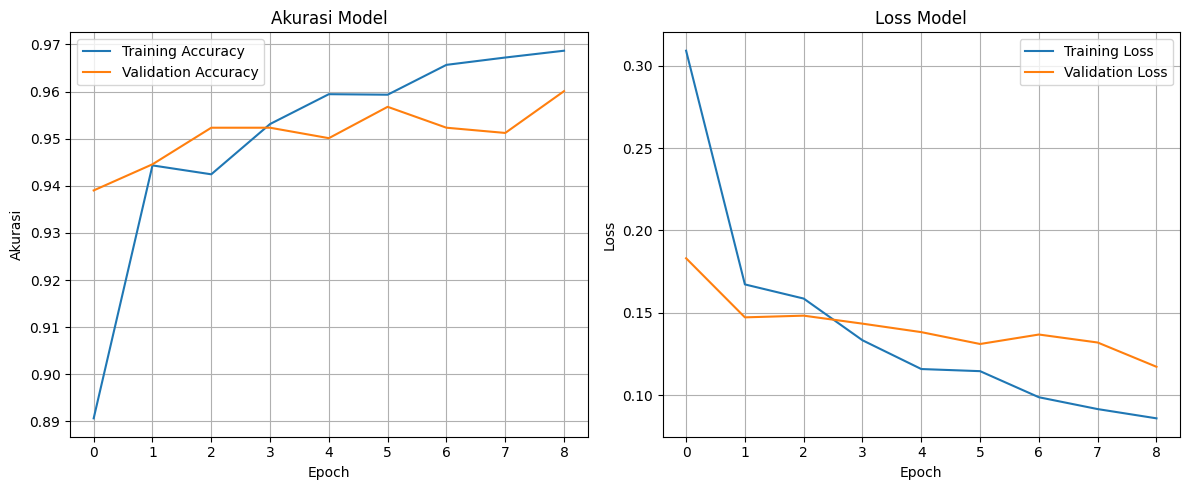

In [15]:
# Plot akurasi
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Akurasi Model')
plt.xlabel('Epoch')
plt.ylabel('Akurasi')
plt.legend()
plt.grid(True)

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss Model')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

Hasil pelatihan model menunjukkan akurasi training yang tinggi, dimulai dari 0.97 dan menurun secara bertahap hingga 0.90 seiring peningkatan epoch, sementara nilai loss turun stabil dari 0.30 menjadi 0.10, mengindikasikan proses pembelajaran yang efektif.

#**Simpan model**

##saved_model.keras

In [16]:
# Simpan model ke format SavedModel
model.save('saved_model.keras')


##TF-Lite

In [17]:
import tensorflow as tf

# Convert model ke format TF-Lite
converter = tf.lite.TFLiteConverter.from_keras_model(model)
tflite_model = converter.convert()

# Simpan model TF-Lite
with open('TF-Lite model.tflite', 'wb') as f:
    f.write(tflite_model)


Saved artifact at '/tmp/tmpbnd2a65g'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name='keras_tensor_238')
Output Type:
  TensorSpec(shape=(None, 5), dtype=tf.float32, name=None)
Captures:
  139133859736720: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  139133859730192: TensorSpec(shape=(1, 1, 1, 3), dtype=tf.float32, name=None)
  139133862905808: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139133862908304: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139133862905616: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139133862908496: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139133862905040: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139133862909840: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139133862910416: TensorSpec(shape=(), dtype=tf.resource, name=None)
  139133862910224: TensorSpec(shape=(), dtype=tf.resource, name=

##tfjs_model

In [18]:
!pip install tensorflowjs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.0/53.0 kB 6.2 MB/s eta 0:00:00
  Attempting uninstall: packaging
    Found existing installation: packaging 24.2
    Uninstalling packaging-24.2:
      Successfully uninstalled packaging-24.2
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-cloud-bigquery 3.31.0 requires packaging>=24.2.0, but you have packaging 23.2 which is incompatible.


In [19]:
import tensorflowjs as tfjs
# Convert model ke format TFJS
tfjs.converters.save_keras_model(model, 'tfjs_model')

failed to lookup keras version from the file,
    this is likely a weight only file
weight normalization/count with shape () and dtype int64 was auto converted to the type int32


#**Inferensi Model**

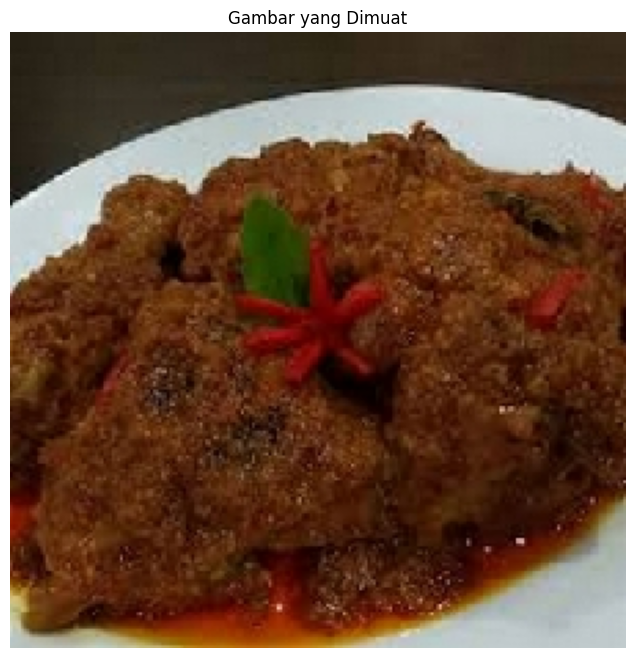

Prediksi: [[0.00117228 0.06094201 0.4440586  0.49323392 0.00059316]]


In [20]:
import tensorflow as tf
from tensorflow.keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt
import os


interpreter = tf.lite.Interpreter(model_path='TF-Lite model.tflite')
interpreter.allocate_tensors()

input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

# Path gambar - sesuaikan dengan struktur aktual
img_path = 'dataset_food/test/rendang/rendang-22084.jpg'

# Fungsi untuk menampilkan gambar
def display_image(img_path):
    try:
        # Memuat gambar
        img = image.load_img(img_path, target_size=(224, 224))

        # Menampilkan gambar
        plt.figure(figsize=(8, 8))
        plt.imshow(img)
        plt.axis('off')
        plt.title('Gambar yang Dimuat')
        plt.show()

        return img
    except Exception as e:
        print(f"Gagal memuat gambar: {str(e)}")
        return None

# Memanggil fungsi untuk menampilkan gambar
img = display_image(img_path)

# Jika ingin melanjutkan dengan prediksi (pastikan model sudah dimuat)
if img is not None:
    try:
        img_array = image.img_to_array(img)
        img_array = np.expand_dims(img_array, axis=0)
        img_array /= 255.0  # Normalisasi

        input_data = img_array.astype(np.float32)

        # Set the input tensor
        interpreter.set_tensor(input_details[0]['index'], input_data)

        # Run inference
        interpreter.invoke()

        # Get the output tensor
        predictions = interpreter.get_tensor(output_details[0]['index'])

        print("Prediksi:", predictions)
    except Exception as e:
        print(f"Error dalam preprocessing: {str(e)}")

gambar rendang tersebut sesuai dengan yang ada didalam dataset dan prediksi numrik, menunjukkan hasil inferensi yang sangat akurat menggunakan TF-Lite